In [1]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from scipy.sparse import coo_matrix
from scipy.sparse import load_npz
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scale input and output data
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(128, num_output_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)

        x = self.conv3(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)

        return x


# Load your input and output data
input_data = np.load('../../WaveSuite/regularWave_U_data_0_to_131.npy')
output_data = np.load('../../WaveSuite/regularWave_nut_data_0_to_131.npy')
output_data = np.expand_dims(output_data, 2)
#Load adjacency matrix
adjacency_matrix = load_npz('../preprocessing/sparse_adjacency_matrix.npz')

In [4]:
def scaler(x, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xScaled = scale * x + min - xmin * scale
    return xScaled

min_input = np.min(input_data, 0)
max_input = np.max(input_data, 0)
min_output = np.min(output_data, 0)
max_output = np.max(output_data, 0)
minimum = 0
maximum = 1


scaled_input_data = scaler(input_data, min_input, max_input, minimum, maximum)
scaled_output_data = scaler(output_data, min_output, max_output, minimum, maximum)

# Prepare edge_index
rows, cols = adjacency_matrix.nonzero()
edge_index = torch.tensor([rows, cols], dtype=torch.long)

# Define the dataset as a list of Data objects
all_data = []
for i in range(input_data.shape[0]):
    x = torch.tensor(scaled_input_data[i, :, :], dtype=torch.float)
    y = torch.tensor(scaled_output_data[i, :, :], dtype=torch.float)
    data = Data(x=x, y=y, edge_index=edge_index)
    all_data.append(data)

# Now we split our dataset into training and testing sets
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# Model
model = Net(num_node_features=input_data.shape[2], num_output_features=output_data.shape[2])
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
model.train()
for epoch in range(50):
    for data in train_data:
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y)  # MSE loss for regression
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Test
model.eval()
correct = 0
for data in test_data:
    with torch.no_grad():
        predictions = model(data)
        correct += F.mse_loss(predictions, data.y).item()

print(f'Test MSE: {correct / len(test_data)}')


Epoch: 0, Loss: 0.030350619927048683
Epoch: 10, Loss: 0.007992344908416271
Epoch: 20, Loss: 0.007678485941141844
Epoch: 30, Loss: 0.007639199495315552
Epoch: 40, Loss: 0.0076232487335801125
Test MSE: 0.00656849012227246


In [5]:
epoch

49

In [6]:
torch.save(model, '../GNN/models/GCN_rW.pth')
torch.save(model.state_dict(), '../GNN/models/GCN_rW_params.pth')
print('models saved!')


models saved!


In [7]:
import torch
import onnx
from onnx_tf.backend import prepare

# Dummy Input
num_nodes = adjacency_matrix.shape[0]  # or replace with actual number of nodes in your graph
num_node_features = input_data.shape[1]  # or replace with actual number of node features in your graph
dummy_input = Data(x=torch.randn(num_nodes, num_node_features), 
                   edge_index=edge_index, 
                   y=torch.randn(num_nodes,))

# Export to ONNX
torch.onnx.export(model, (dummy_input.x, dummy_input.edge_index), 'model.onnx')

# Load the ONNX model
onnx_model = onnx.load('model.onnx')

# Convert to TensorFlow format
tf_rep = prepare(onnx_model)

# Save model as .pb
tf_rep.export_graph('model.pb')


2023-06-13 13:19:30.643603: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 13:19:30.788757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 13:19:31.376016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/caq13/miniconda3/envs/ws-pred/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and relea

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 387389228836 bytes. Error code 12 (Cannot allocate memory)

In [8]:
y_pred = np.zeros((26, 311203, 1))
test_data_collect = np.zeros((26, 311203, 1))

for i in range(len(test_data)- 1):
    y_pred[i, :, :] = model(test_data[i]).detach().numpy()
    test_data_collect[i, :, :] = test_data[i].y
y_pred = np.squeeze(y_pred)
y_pred = scaler_output.inverse_transform(y_pred)
np.save('./y_pred.npy', y_pred)
test_data_collect = np.squeeze(test_data_collect)
np.save('./test_data.npy', test_data_collect)
print('Saved!')


Saved!


(311203, 1)


/tmp/ipykernel_1320156/793133536.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions.detach().numpy())
/tmp/ipykernel_1320156/793133536.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_data[k].y)


torch.Size([311203, 1])


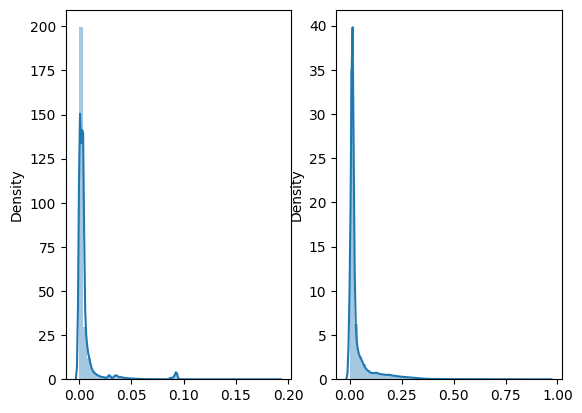

In [10]:
k = 13
predictions = model(test_data[k])
predictions
print(predictions.detach().numpy().shape)
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
sns.distplot(predictions.detach().numpy())
plt.subplot(1,2,2)
sns.distplot(test_data[k].y)
print(test_data[k].y.shape)


In [25]:
test_data[0].y

tensor([[5.7364e-05],
        [5.4758e-05],
        [5.4296e-05],
        ...,
        [4.8097e-06],
        [1.3074e-06],
        [1.4395e-06]])

In [35]:
import pyvista as pv
#Add mesh
mesh_to_print = pv.read('../../WaveSuite/regularWave/regularWave_1.vtu')

mesh_to_print['nut'] = predictions.detach().numpy()


In [ ]:
import pyvista as pv

# Create a plotter object
plotter = pv.Plotter()

# Load your mesh
mesh = pv.read('../../WaveSuite/regularWave/regularWave_1.vtu')

# Add the mesh to the plotter
plotter.add_mesh(mesh)

# Set view if needed
# plotter.view_xyz()  # this is just an example

# Save screenshot
plotter.screenshot('mesh_screenshot.png')